In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:


dataset = read_csv("seg_data2.csv",
                   parse_dates={'ST' : ['StartTime']},
                   infer_datetime_format=True, 
                   index_col= 1,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values


In [3]:
dataset.head(4)

,ST,Start,EndTime,Speed
Segment_ID,,,,
1071707139,2021-07-06 00:00:00,44383.00000,7/6/2021 0:30,95.933333
1071707139,2021-07-06 00:30:00,44383.02083,7/6/2021 1:00,100.000000
1071707139,2021-07-06 01:00:00,44383.04167,7/6/2021 1:30,90.666667
1071707139,2021-07-06 01:30:00,44383.06250,7/6/2021 2:00,100.000000


In [4]:
dataset.index.unique()

Int64Index([1071707139, 1071845897,  226926090,  226926091, 1071754251,
            1071863817,  227035662, 1071707154, 1071754259, 1071863833,
            ...
            1071754214, 1071845863, 1071703530, 1071729645, 1071707121,
            1071832566, 1071863801, 1071845882, 1071754235, 1071729662],
           dtype='int64', name='Segment_ID', length=197)

In [5]:
dataset.drop(columns  = [ 'EndTime','ST'], inplace = True)

In [6]:
dataset.head()

,Start,Speed
Segment_ID,,
1071707139,44383.00000,95.933333
1071707139,44383.02083,100.000000
1071707139,44383.04167,90.666667
1071707139,44383.06250,100.000000
1071707139,44383.08333,100.000000


In [7]:
len(dataset.index)

9456

In [8]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [9]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [10]:
scaled.head(4)

,0,1
0,0.000000,0.636190
1,0.019531,0.675056
2,0.042969,0.585855
3,0.062500,0.675056


In [11]:
def create_ts_data(dataset, lookback=1, predicted_col=2):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [12]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,1)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)
id                                 
1    0.000000   0.636190   0.675056
2    0.019531   0.675056   0.585855
3    0.042969   0.585855   0.675056
4    0.062500   0.675056   0.675056


In [13]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [14]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6619, 1, 2) (6619,) (2836, 1, 2) (2836,)


In [15]:
model_lstm = Sequential()
model_lstm.add(LSTM(512, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=80, return_sequences=True))
model_lstm.add(LSTM(units=80))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 512)            1054720   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 80)             189760    
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 1,296,081
Trainable params: 1,296,081
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=100,validation_data=(test_X, test_y), batch_size=50, shuffle=False)

Epoch 1/100
104/104 [==============================] - 18s 24ms/step - loss: 0.3401 - val_loss: 0.0671
Epoch 2/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0591 - val_loss: 0.0626
Epoch 3/100
104/104 [==============================] - 1s 10ms/step - loss: 0.0586 - val_loss: 0.0626
Epoch 4/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0584 - val_loss: 0.0614
Epoch 5/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0581 - val_loss: 0.0623
Epoch 6/100
104/104 [==============================] - 1s 8ms/step - loss: 0.0580 - val_loss: 0.0606
Epoch 7/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0577 - val_loss: 0.0596
Epoch 8/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0573 - val_loss: 0.0639
Epoch 9/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0575 - val_loss: 0.0633
Epoch 10/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0572 - val

In [17]:
pred_y =  model_lstm.predict(test_X)

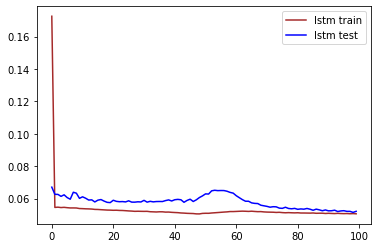

In [18]:
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [19]:
test_y.reshape(2836,1)

array([[0.601784  ],
       [0.7228416 ],
       [0.6285441 ],
       ...,
       [0.65466714],
       [0.54412234],
       [0.562281  ]], dtype=float32)

In [20]:
pred_y

array([[0.6828127 ],
       [0.6663457 ],
       [0.6900218 ],
       ...,
       [0.68845165],
       [0.68130344],
       [0.64473057]], dtype=float32)

0.005162188
0.43116661587905214
0.07184836707932496
0.05214031


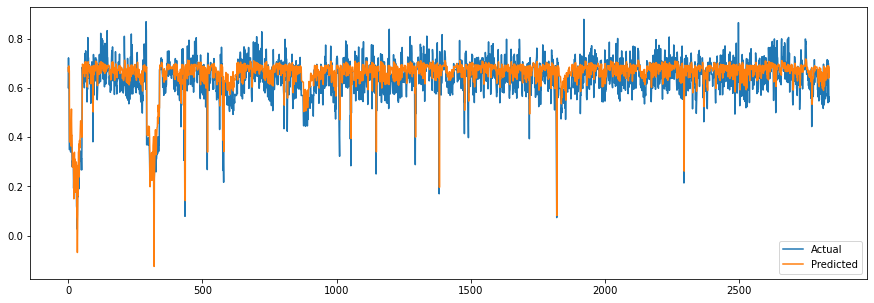

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

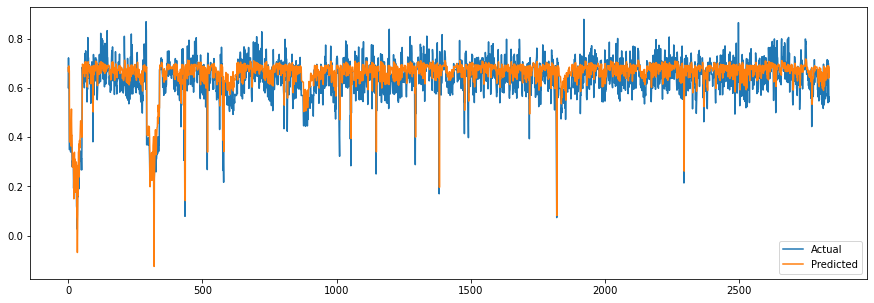

In [22]:
#visualization over full data
tra = test_X
tes =test_y
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

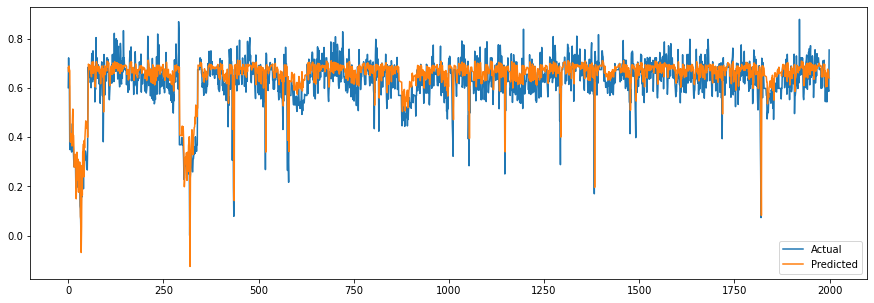

In [23]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()